In [1]:
%matplotlib widget

In [2]:
import sys
sys.path.append('../external/tslib')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import csv
import os
import json
import time
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from dataclasses import dataclass, field
from typing import List, Optional


@dataclass
class Task:
    id: str
    request_time: int
    duration: int
    start_time: Optional[int] = None
    end_time: Optional[int] = None
    assigned_worker: Optional[str] = None

    def __str__(self):
        return f"Task({self.id}|{self.duration}ms|{self.assigned_worker}|{self.request_time}-{self.start_time}-{self.end_time})"

@dataclass
class MetricsDataPoint:
    time: int = 0
    expected_workers: int = 0
    active_workers: int = 0
    total_workers: int = 0
    num_new_tasks: int = 0
    num_ongoing_tasks: int = 0
    num_queued_tasks: int = 0
    num_completed_tasks: int = 0
    avg_delay: float = 0.0
    avg_duration: float = 0.0
    reward: float = 0.0
    completed_tasks: List['Task'] = field(default_factory=list)
    
def generate_reward_function(metrics_window: float, value_per_task: float = 0.001, cost_per_worker_hour: float = 1, delay_threshold: int = 8000) -> float:
    # Example reward function: negative of average delay
    return lambda metrics: (
        sum([0 if (task.end_time - task.request_time) > delay_threshold else value_per_task for task in metrics.completed_tasks]) -
        cost_per_worker_hour * (metrics.total_workers * metrics_window / 3600000 )
    )

class Worker:
    def __init__(self, init_time: int = 0):
        self.id = "worker-" + str(random.randint(0, 10000))
        self.available_at = init_time
        self.active = False  # 是否已经初始化完成

    def assign_task(self, task: Task, current_time: int):
        if current_time < self.available_at:
            task.start_time = self.available_at
            self.available_at += task.duration
        else:
            task.start_time = current_time
            self.available_at = current_time + task.duration
        task.end_time = self.available_at
        task.assigned_worker = self.id
    
    def is_available(self, current_time: int) -> bool:
        return self.available_at <= current_time and self.active
    


class Simulator:
    def __init__(self, tasks: List[Task], init_workers: int = 1, worker_init_time_min : int = 12000, worker_init_time_max : int = 12000, metrics_window: int = 10000, reward_function=None):
        self.tasks = sorted(tasks, key=lambda t: t.request_time)
        self.time = 0  
        self.metrics_window = metrics_window
        self.worker_init_time_min = worker_init_time_min
        self.worker_init_time_max = worker_init_time_max
        self.expected_workers = init_workers
        self.workers = [Worker(self.__get_worker_init_time()) for i in range(init_workers)]
        self.terminating_workers: List[Task] = []
        self.in_progress: List[Task] = []
        self.queued: List[Task] = []
        self.completed_tasks: List[Task] = []

        self.new_tasks = 0
        self.metrics: List[MetricsDataPoint] = []
        self.reward_function = reward_function

    def tick(self): # tick 1s
        self.time += 1000
        # check completed tasks
        for task in self.in_progress:
            if task.end_time <= self.time:
                self.completed_tasks.append(task)
                self.in_progress.remove(task)
        # check initialized workers
        for w in self.workers:
            if not w.active and self.time >= w.available_at:
                w.active = True
        # check terminating workers
        self.terminating_workers = [w for w in self.terminating_workers if w.available_at >= self.time]
        
        worker = self.__get_available_worker(self.time)
        # pop queued tasks
        while worker and self.queued:
            task = self.queued.pop(0)
            worker.assign_task(task, task.request_time)
            self.in_progress.append(task)
            worker = self.__get_available_worker(self.time)
        # pop new tasks
        while self.tasks and self.tasks[0].request_time < self.time:
            task = self.tasks.pop(0)
            self.new_tasks += 1
            if worker:
                worker.assign_task(task, self.time)
                self.in_progress.append(task)
                worker = self.__get_available_worker(self.time)
            else:
                self.queued.append(task)
        # report metrics
        if self.time % self.metrics_window == 0:
            self.report_metrics()

    def scale(self, expected_workers: int):
        if expected_workers > self.expected_workers:
            for _ in range(expected_workers - self.expected_workers):
                worker = Worker(self.time + self.__get_worker_init_time())
                self.workers.append(worker)
        elif expected_workers < self.expected_workers:
            for _ in range(self.expected_workers - expected_workers):
                for w in self.workers:
                    if not w.active:
                        worker = w
                        self.workers.remove(worker)
                        break
                else:
                    worker = self.workers.pop()
                self.terminating_workers.append(worker)
        self.expected_workers = expected_workers

    def report_metrics(self):
        if self.completed_tasks:
            avg_delay = int(np.mean([t.end_time - t.request_time for t in self.completed_tasks]))
            avg_duration = int(np.mean([t.end_time - t.start_time for t in self.completed_tasks]))
        else:
            avg_delay = 0
            avg_duration = 0
        dataPoint = MetricsDataPoint(
            time=self.time,
            expected_workers=self.expected_workers,
            active_workers=len([w for w in self.workers if w.active]),
            total_workers=len(self.workers) + len(self.terminating_workers),
            num_new_tasks=self.new_tasks,
            num_ongoing_tasks=len(self.in_progress) + len(self.queued),
            num_queued_tasks=len(self.queued),
            num_completed_tasks=len(self.completed_tasks),
            avg_delay=avg_delay,
            avg_duration=avg_duration,
            completed_tasks=self.completed_tasks.copy(),
            reward=0,  # Placeholder for reward, to be calculated later
        )
        if self.reward_function:
            dataPoint.reward = self.reward_function(dataPoint)
        self.metrics.append(dataPoint)
        self.completed_tasks.clear()
        self.new_tasks = 0
        
    def plot_metrics(self, tmp_output_dir: str = None):
        metric_keys = [
            'expected_workers',
            'active_workers',
            'total_workers',
            'num_new_tasks',
            'num_ongoing_tasks',
            'num_queued_tasks',
            'num_completed_tasks',
            'avg_delay',
            'avg_duration',
            'reward'
        ]

        data = {key: [] for key in metric_keys}
        time_s = [int(m.time / 1000) for m in self.metrics]

        for metrics in self.metrics:
            for key in metric_keys:
                data[key].append(getattr(metrics, key))

        fig, axes = plt.subplots(len(metric_keys), 1, figsize=(14, 20), sharex=True)

        for ax, key in zip(axes, metric_keys):
            ax.plot(time_s, data[key], label=key)
            ax.set_ylabel(key)
            ax.grid(True)
            ax.legend(loc='upper left')

        axes[-1].set_xlabel("Time (s)")
        fig.tight_layout()
        if tmp_output_dir:
            plt.savefig(os.path.join(tmp_output_dir, "metrics_plot.png"), dpi=300)
        else:
            plt.show()

    def __get_available_worker(self, current_time: int) ->Optional[Worker]:
        # FIFO
        available_worker, min_available_at = None, float('inf')
        for worker in self.workers:
            if worker.is_available(current_time) and worker.available_at < min_available_at:
                min_available_at = worker.available_at
                available_worker = worker
        return available_worker
    
    def __get_worker_init_time(self) -> int:
        return random.randint(self.worker_init_time_min, self.worker_init_time_max)


In [4]:
from datetime import timedelta

def extract_continuous_segment(df, week_count, day_count, time_scale, request_scale):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df.sort_values('timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # 设置时间戳为索引
    df.set_index('timestamp', inplace=True)

    # 获取数据的起始和结束时间
    start_time = df.index.min()
    end_time = df.index.max()

    # 计算所需的总天数
    total_days = week_count * 7 + day_count

    # 查找所有满足条件的连续时间段
    valid_starts = []
    if week_count > 0:
        # 计算所有可能的周一 00:00 的时间点
        valid_starts = pd.date_range(start=start_time, end=end_time - timedelta(days=total_days), freq='W-MON')
    else:
        # 计算所有可能的起始时间点
        valid_starts = pd.date_range(start=start_time, end=end_time - timedelta(days=total_days), freq='D')

    if valid_starts.empty:
        print("❌ 数据中没有满足条件的连续时间段。")
        return

    # 随机选择一个起始时间
    selected_start = random.choice(valid_starts)
    selected_end = selected_start + timedelta(days=total_days)
    print(f"✅ 选中的时间段：{selected_start} 到 {selected_end}")

    # 提取选中的数据段
    segment = df.loc[selected_start:selected_end].copy()
    if segment.empty:
        print("⚠️ 选中的时间段内没有数据。")
        return

    # 重置时间戳，从 0 开始，并应用时间缩放
    segment.reset_index(inplace=True)
    base_time = segment['timestamp'].min()
    segment['timestamp'] = segment['timestamp'].apply(lambda x: int((x - base_time).total_seconds() / time_scale))

    # 应用请求数缩放
    segment['requests'] = segment['requests'] / request_scale

    return segment[['timestamp', 'requests']].reset_index(drop=True), base_time

def schedule_requests_from_csv(requests_df, rate_df):
    # 打乱请求顺序
    requests_df = requests_df.sample(frac=1).reset_index(drop=True)

    result_rows = []
    request_index = 0
    accum = 0.0  # 累积速率

    for _, rate_row in rate_df.iterrows():
        timestamp_base = float(rate_row['timestamp'])
        rps = float(rate_row['requests'])

        accum += rps
        num_requests = int(accum)
        accum -= num_requests  # 保留小数部分

        for _ in range(num_requests):
            if request_index >= len(requests_df):
                break
            row = requests_df.iloc[request_index].copy()
            # 在[T, T+1)内均匀分布]
            row['timestamp'] = timestamp_base + random.uniform(0, 1)
            result_rows.append(row)
            request_index += 1

        if request_index >= len(requests_df):
            break
    
    # sort by timestamp
    result_rows.sort(key=lambda x: x['timestamp'])

    # 创建结果 DataFrame
    return pd.DataFrame(result_rows, columns=['Id', 'Duration', 'timestamp']).rename(columns={'Id': 'id', 'Duration': 'duration'})

def generate_tasks_from_csv(requests_csv_path, rate_csv_path, week_count=0, day_count=3, scale = 0.8, tmp_output_dir = None):
    # 读取请求数据
    requests_df = pd.read_csv(requests_csv_path)
    rate_df = pd.read_csv(rate_csv_path)

    # 提取连续时间段
    segment, base_time = extract_continuous_segment(rate_df, week_count, day_count, 120, 120 * 1 / scale)
    if segment is None:
        return None
    
    tasks_df = schedule_requests_from_csv(requests_df, segment)
    if tasks_df is None:
        return None
    
    time_start = tasks_df['timestamp'].min() 
    tasks_df['timestamp'] = tasks_df['timestamp'].apply(lambda x: int((x - time_start) * 1000))  # 转换为毫秒
    tasks_df['id'] = tasks_df['id'].astype(int)
    tasks_df['duration'] = tasks_df['duration'].astype(int)

    if tmp_output_dir:
        tmp_output_path = os.path.join(tmp_output_dir, 'tasks.csv')
        if not os.path.exists(tmp_output_dir):
            os.makedirs(tmp_output_dir)
        tasks_df.to_csv(tmp_output_path, index=False)
        print(f"✅ 生成的任务数据已保存到 {tmp_output_path}")
        # 保存basetime等元信息为json文件
        meta_info = {'base_time': base_time.isoformat(), 'week_count': week_count, 'day_count': day_count, 'scale': scale}
        meta_info_path = os.path.join(tmp_output_dir, 'meta_info.json')
        with open(meta_info_path, 'w') as f:
            json.dump(meta_info, f)
        print(f"✅ 生成的元数据已保存到 {meta_info_path}")

    tasks = [Task(id=row['id'], request_time=row['timestamp'], duration=row['duration']) for _, row in tasks_df.iterrows()]
    return tasks, base_time

def load_tasks_from_csv(tmp_output_dir = 'rl/tmp'):
    tasks_df = pd.read_csv(os.path.join(tmp_output_dir, 'tasks.csv'))
    tasks = [Task(id=row['id'], request_time=row['timestamp'], duration=row['duration']) for _, row in tasks_df.iterrows()]
    # 读取元信息
    with open(os.path.join(tmp_output_dir, 'meta_info.json'), 'r') as f:
        meta_info = json.load(f)
        base_time = pd.to_datetime(meta_info['base_time'])

    return tasks, base_time

def save_metrics_to_csv(metric_history, tmp_output_dir = 'rl/tmp'):
    os.makedirs(tmp_output_dir, exist_ok=True)

    # Build DataFrame
    df = pd.DataFrame(metric_history)
    df['time'] = df['time'].apply(lambda x: int(x / 1000)) 
    df['reward'] = df['reward'].apply(lambda x: round(x, 4))
    df['completed_tasks'] = df['completed_tasks'].apply(lambda x: ','.join([f"Task({t['id']}|{t['duration']}ms|{t['assigned_worker']}|{t['request_time']}-{t['start_time']}-{t['end_time']})" for t in x]))

    # Write to CSV
    out_path = os.path.join(tmp_output_dir, 'metrics.csv')
    df.to_csv(out_path, index=False)
    print(f"✅ 生成的指标数据已保存到 {out_path}")
    

In [5]:
day_count = 3
scale = 1.5
request_mean = 3.69341263 * scale
request_std = 2.05966675 * scale
iterations = 60 * 12 * day_count
init_workers = 1
min_workers = 1
max_workers = 6
worker_init_time_min = 40
worker_init_time_max = 40
metrics_window = 10
forecast_window = 36
observe_length = 3
future_length = 12
reward_function = generate_reward_function(metrics_window * 1000, value_per_task=0.002, cost_per_worker_hour=1, delay_threshold=8000)

In [58]:
tasks, base_time = generate_tasks_from_csv(
    requests_csv_path='../data/test_regression_clipped.csv',
    rate_csv_path='../data/request_timeseries_test.csv',
    week_count=0,
    day_count=day_count,
    scale=scale,
    tmp_output_dir='rl/tmp'
)

✅ 选中的时间段：2025-04-01 17:48:00+00:00 到 2025-04-04 17:48:00+00:00
✅ 生成的任务数据已保存到 rl/tmp/tasks.csv
✅ 生成的元数据已保存到 rl/tmp/meta_info.json


In [17]:
tasks, _ = load_tasks_from_csv('rl/tmp')
simulator = Simulator(tasks, 1, worker_init_time_min * 1000, worker_init_time_max * 1000, metrics_window * 1000,
                      reward_function=reward_function
)
for i in range(iterations):
    simulator.tick()

print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

🤩 总reward为： -0.5339999999999987
✅ 生成的指标数据已保存到 rl/tmp/metrics.csv


In [6]:
class QueueSizeScaleStrategy:
    def __init__(self, 
                 min_workers: int = min_workers,
                 max_workers: int = max_workers,
                 aggressive_scale: bool = False,
                 target_ongoing_tasks: int = 3, 
                 scale_up_window: int = 1, 
                 scale_down_window: int = 1):
        self.min_workers = min_workers
        self.max_workers = max_workers
        self.aggressive_scale = aggressive_scale
        self.target_ongoing_tasks = target_ongoing_tasks
        self.scale_up_window = scale_up_window
        self.scale_down_window = scale_down_window

    def calc(self, current_expected_workers: int, metrics: List[MetricsDataPoint]) -> int:
        if len(metrics) < self.scale_up_window or len(metrics) < self.scale_down_window:
            return current_expected_workers
        # Calculate the average number of ongoing tasks over the last scale_up_window iterations
        avg_ongoing_tasks_up = np.mean([m.num_ongoing_tasks + m.num_new_tasks for m in metrics[-self.scale_up_window:]])
        # Calculate the average number of ongoing tasks over the last scale_down_window iterations
        avg_ongoing_tasks_down = np.mean([m.num_ongoing_tasks + m.num_new_tasks for m in metrics[-self.scale_down_window:]])
        # Scale up if the average number of ongoing tasks is greater than the target
        new_workers = current_expected_workers
        running_workers = max(1, metrics[-1].active_workers)
        if avg_ongoing_tasks_up > self.target_ongoing_tasks * running_workers:
            new_workers = np.ceil(avg_ongoing_tasks_up / self.target_ongoing_tasks)
            if not self.aggressive_scale and new_workers > current_expected_workers:
                new_workers = current_expected_workers + 1
            new_workers = min(new_workers, self.max_workers)

        if avg_ongoing_tasks_down < self.target_ongoing_tasks * running_workers:
            new_workers = np.ceil(avg_ongoing_tasks_down / self.target_ongoing_tasks)
            if not self.aggressive_scale and new_workers < current_expected_workers:
                new_workers = current_expected_workers - 1
            new_workers = max(new_workers, self.min_workers)

        return int(new_workers)

🤩 总reward为： 0.6114444444444449
✅ 生成的指标数据已保存到 rl/tmp/metrics.csv


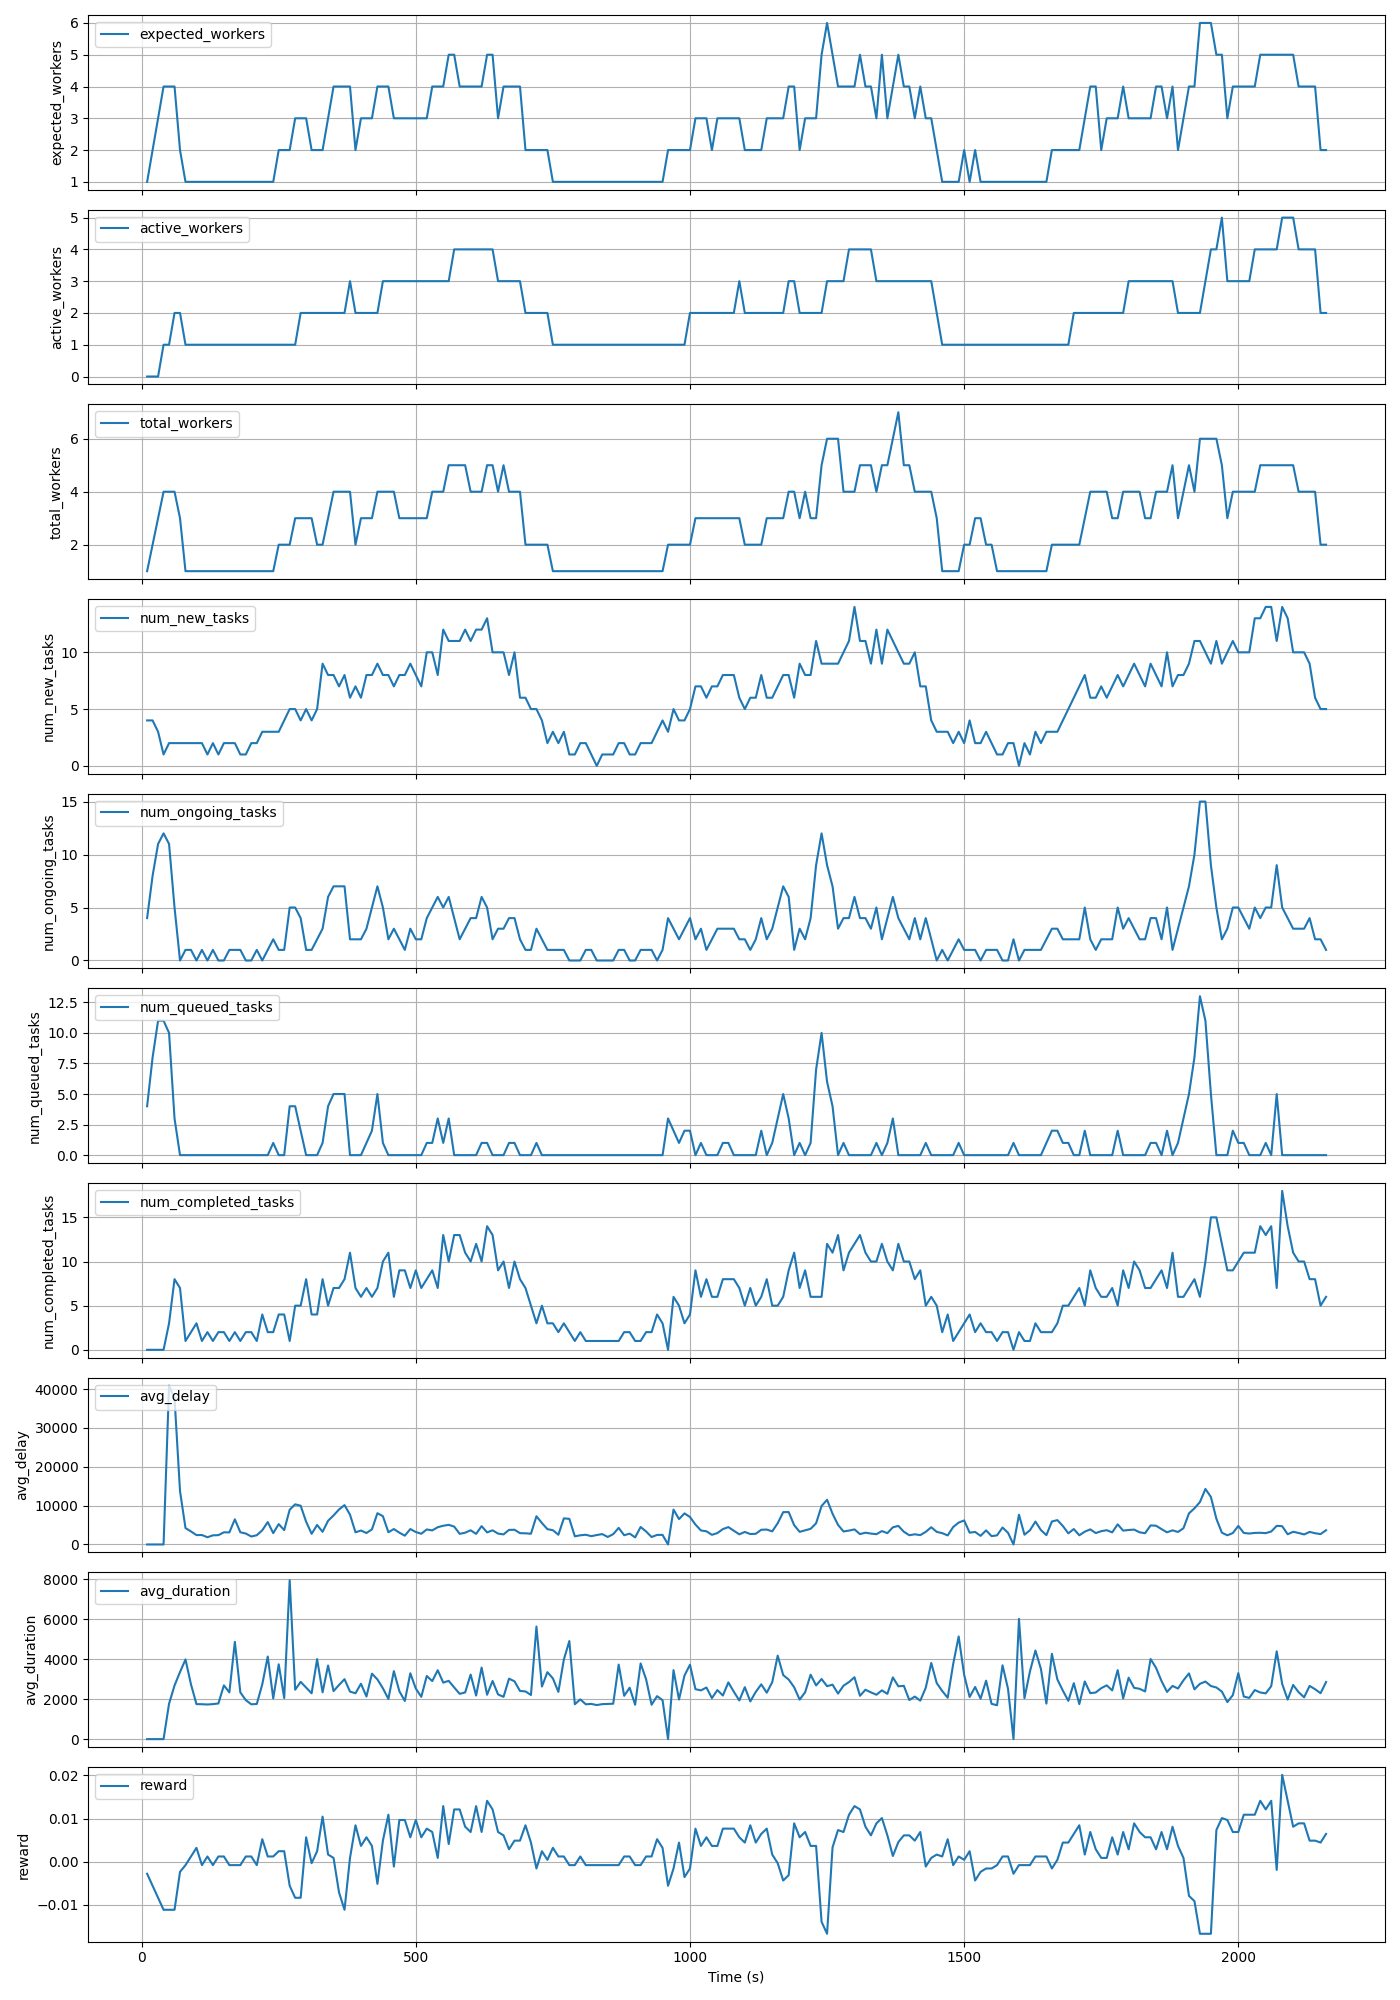

In [7]:
strategy = QueueSizeScaleStrategy(
    min_workers=min_workers,
    max_workers=max_workers,
    aggressive_scale=True,
    target_ongoing_tasks=4,
    scale_up_window=1,
    scale_down_window=1
)
tasks, _ = load_tasks_from_csv('rl/tmp')
simulator = Simulator(tasks, init_workers, worker_init_time_min * 1000, worker_init_time_max * 1000, metrics_window * 1000,
                      reward_function=reward_function
)
for i in range(iterations):
    simulator.tick()
    if i > 0 and i % metrics_window == 0:
        expected_workers = strategy.calc(simulator.expected_workers, simulator.metrics)
        simulator.scale(expected_workers)
print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

In [6]:

import gymnasium as gym
from gymnasium.spaces import Discrete, Box
from lib.forecast.tslib_util import (
    TimeseriesForecaster,
    TimeseriesTransformer
)

class WorkerScaling(gym.Env):

    FEATURE_MIN = {
        "running_workers": 0,
        "new_requests": 0,
        "ongoing_requests": 0,
        "finished_requests": 0,
        "requests_delay": 0.0,
        "requests_duration": 0.0,
        "forecasted_requests": 0.0,
    }

    FEATURE_MAX = {
        "running_workers": max_workers,         
        "new_requests": scale * 10,            
        "ongoing_requests": scale * 50,        
        "finished_requests": max_workers * 6,       
        "requests_delay": scale * 20000,          
        "requests_duration": 12000, 
        "forecasted_requests": scale * 10,      
    }

    def __init__(self, config: Optional[dict] = None):
        self.config = config or {}
        self.observe_length = self.config.get("observe_length", 36)
        self.future_length = self.config.get("future_length", 36)
        self.action_space = Discrete(max_workers)
        self.observation_space = Box(0.0, 1.0, shape=(self.observe_length * 6 + self.future_length,), dtype=np.float32)
        self.time_s = 0

        self.forecaster = TimeseriesForecaster()

        random.seed(int(seed + self.config.get("worker_index", 0)) % 99999)
        np.random.seed(int(seed + self.config.get("worker_index", 0)) % 99999)


    def reset(self, *, seed=None, options=None):
        self.time_s = 0
        self.init_simulator()
        # Return obs and (empty) info dict.
        return self.extract_observation_window(self.simulator.metrics), {"env_state": "reset"}

    def step(self, action):
        assert action in range(max_workers), f"Invalid action {action}"
        
        self.simulator.scale(action + min_workers)
        for _ in range(metrics_window):
            self.simulator.tick()
            self.time_s += 1
            if self.time_s >= iterations:
                break

        terminated = self.time_s >= iterations
        truncated = False


        reward = self.simulator.metrics[-1].reward
        infos = {}
        return (
            self.extract_observation_window(self.simulator.metrics),
            reward,
            terminated,
            truncated,
            infos,
        )
    
    def init_simulator(self, tasks=None, base_time=None):
        if tasks is None:
            tasks, base_time = generate_tasks_from_csv(
                requests_csv_path='../data/train_regression_clipped.csv',
                rate_csv_path='../data/request_timeseries_train.csv',
                week_count=0,
                day_count=day_count,
                scale=scale,
            )
        self.simulator = Simulator(tasks, 1, worker_init_time_min* 1000, worker_init_time_max *1000, metrics_window * 1000, reward_function)

        self.forecaster.setTransformer(
            transformer=TimeseriesTransformer(
                date_start=base_time.timestamp(), date_scale=120, scale=True,
                scale_mean=request_mean, scale_std=request_std
            )
        )

        self.iteration = 0
        self.max_iterations = len(tasks) * 2

    
    def extract_observation_window(self, data: List[MetricsDataPoint]) -> np.ndarray:

        # get forecasted data

        obs = np.zeros((self.observe_length * 6 + self.future_length,), dtype=np.float32)
        if len(data) == 0:
            return obs

        if len(data) >= forecast_window:
            forecast_metrics =  data[-forecast_window:]
            recent_new_request = [0 if not m else m.num_new_tasks for m in forecast_metrics]
            recent_timestamp = [self.time_s - i * metrics_window for i in range(forecast_window-1, -1, -1)]
            future_requests = self.forecaster.forecast(
                enc_data=recent_new_request,
                enc_stamp=recent_timestamp,
            )[:self.future_length]
        else:
            future_requests = np.zeros(self.future_length, dtype=np.float32)

        # print(f"Recent requests:{recent_new_request} \n---\n Forecasted future requests: {future_requests}")

        recent = data[-self.observe_length:] if len(data) >= self.observe_length else [None] * (self.observe_length - len(data)) + data
        for i, point in enumerate(recent + list(future_requests)):
            if point is None:
                continue  # Keep default zeros for padding

            observed = isinstance(point, MetricsDataPoint)
            features = [
                ("running_workers", point.active_workers),
                ("requests_delay", point.avg_delay),
                ("requests_duration", point.avg_duration),
                ("ongoing_requests", point.num_ongoing_tasks),
                ("finished_requests", point.num_completed_tasks),
                ("new_requests", point.num_new_tasks)
            ] if observed else [
                ("new_requests", point)
            ]

            for row, (key, raw_value) in enumerate(features):
                min_val = WorkerScaling.FEATURE_MIN[key]
                max_val = WorkerScaling.FEATURE_MAX[key]
                # Min-max normalization with small epsilon for safety
                norm_val = (raw_value - min_val) / (max_val - min_val + 1e-6)
                norm_val = np.clip(norm_val, 0.0, 1.0)
                if i < self.observe_length:
                    obs[row * self.observe_length + i] = norm_val
                else:
                    obs[6 * self.observe_length + i - self.observe_length] = norm_val

        return obs

In [ ]:
from ray.tune import Callback
from ray.rllib.utils.test_utils import (
    add_rllib_example_script_args,
    run_rllib_example_script_experiment,
)
from ray.rllib.utils.metrics import (
    ENV_RUNNER_RESULTS,
    EPISODE_RETURN_MEAN,
)
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.core.rl_module.default_model_config import DefaultModelConfig
from ray.rllib.algorithms.ppo.torch.default_ppo_torch_rl_module import DefaultPPOTorchRLModule
from ray.rllib.algorithms.ppo import PPOConfig

import lib.model.transformer as transformer

parser = add_rllib_example_script_args(
    default_reward=1.5, default_iters=200, default_timesteps=1000000
)
parser.set_defaults(
    # Make sure that - by default - we produce checkpoints during training.
    checkpoint_freq=10,
    checkpoint_at_end=True,
    # Script only runs on new API stack.
    enable_new_api_stack=True,
)
args = parser.parse_args([])

iter_setps, episode_reward = [], []
class TuneCallback(Callback):
    def on_trial_result(self, iteration, trials, trial, result,
                        **info):
        if result.get(ENV_RUNNER_RESULTS) and result.get(ENV_RUNNER_RESULTS).get(EPISODE_RETURN_MEAN):
            print(f"🤩 step{iteration} 平均reward为 {result[ENV_RUNNER_RESULTS][EPISODE_RETURN_MEAN]}")
            iter_setps.append(iteration)
            episode_reward.append(result[ENV_RUNNER_RESULTS][EPISODE_RETURN_MEAN])

base_config = (
        PPOConfig()
        .api_stack(
            enable_rl_module_and_learner=True,
            enable_env_runner_and_connector_v2=True,
        )
        .rl_module(
            model_config=DefaultModelConfig(
                # fcnet_hiddens=[128, 128],
                fcnet_activation="relu",
                # head_fcnet_hiddens=[32, 32],
                vf_share_layers=True,
            )
        )
        # .rl_module(
        #     rl_module_spec=RLModuleSpec(
        #         module_class=DefaultPPOTorchRLModule,
        #         catalog_class=transformer.TransformerEncoderCatalog,
        #         model_config={
        #             "head_fcnet_hiddens": [128,128],
        #             "head_fcnet_activation": "relu",
        #             "vf_share_layers": True,
        #             "d_model": 128,
        #             "n_layer": 2,
        #             "embedding_dropout": 0,
        #             "embedding_bias": False,
        #             "embedding_position_type": "",
        #         },
        #     ),
        # )
        .env_runners(num_env_runners=8, num_gpus_per_env_runner=0, num_cpus_per_env_runner=0.1)
        .learners(num_gpus_per_learner=1, num_cpus_per_learner=1)
        .training(
            train_batch_size_per_learner = 2000,
            lambda_ = 0.97,
            vf_loss_coeff = 1,
            kl_coeff = 0.2,
            lr = 3e-4
        )
        .environment(
            WorkerScaling,
            env_config={"observe_length": observe_length, "future_length": future_length}
        )

    )

results = run_rllib_example_script_experiment(base_config, args, tune_callbacks=[TuneCallback()])

best_result = results.get_best_result(
    metric=f"{ENV_RUNNER_RESULTS}/{EPISODE_RETURN_MEAN}", mode="max"
)
print(f"Best result: {best_result}")

2025-06-05 18:40:38,267	INFO worker.py:1888 -- Started a local Ray instance.


2025-06-05 18:40:42,730	WARNING algorithm_config.py:4766 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
(PPO pid=5215) 2025-06-05 18:41:26,205	WARNING algorithm_config.py:4766 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html


(SingleAgentEnvRunner pid=5282) Using cpu or mps
(SingleAgentEnvRunner pid=5282) Use CPU


(SingleAgentEnvRunner pid=5282) 2025-06-05 18:42:25,357	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!


(SingleAgentEnvRunner pid=5284) Using cpu or mps [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(SingleAgentEnvRunner pid=5284) Use CPU [repeated 7x across cluster]


(PPO pid=5215) 2025-06-05 18:42:33,494	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future! [repeated 8x across cluster]
(PPO pid=5215) Trainable.setup took 67.713 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=5215) Install gputil for GPU system monitoring.


(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-01-05 13:00:00+00:00 到 2025-01-08 13:00:00+00:00
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2024-12-28 13:00:00+00:00 到 2024-12-31 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-02-20 13:00:00+00:00 到 2025-02-23 13:00:00+00:00 [repeated 5x across cluster]
🤩 step1871 平均reward为 -2.7172499999999955


Trial name,env_runner_group,env_runners,fault_tolerance,learners,num_env_steps_sampled_lifetime,num_env_steps_sampled_lifetime_throughput,num_training_step_calls_per_iteration,perf,timers
PPO_WorkerScaling_c40ae_00000,{'actor_manager_num_outstanding_async_reqs': 0},"{'num_env_steps_sampled': 2000, 'module_to_env_connector': {'timers': {'connectors': {'listify_data_for_vector_env': np.float64(0.00026667664331019166), 'get_actions': np.float64(0.001363530015180732), 'normalize_and_clip_actions': np.float64(0.00021251724645611798), 'un_batch_to_individual_items': np.float64(0.00013642853050459171), 'tensor_to_numpy': np.float64(0.00043051301116224684), 'remove_single_ts_time_rank_from_batch': np.float64(1.5262419974540324e-05)}}, 'connector_pipeline_timer': np.float64(0.003035822803554568)}, 'sample': np.float64(40.04672063519917), 'env_to_module_connector': {'timers': {'connectors': {'add_observations_from_episodes_to_batch': np.float64(6.573198566942746e-05), 'add_time_dim_to_batch_and_zero_pad': np.float64(6.797179341695338e-05), 'batch_individual_items': np.float64(0.00017664872380787584), 'numpy_to_tensor': np.float64(0.00028720521110493704), 'add_states_from_episodes_to_batch': np.float64(3.835854661110614e-05)}}, 'connector_pipeline_timer': np.float64(0.0011188139485200056)}, 'episode_len_min': 216, 'num_episodes': 8, 'episode_return_mean': 0.3848418803418804, 'num_episodes_lifetime': 1852, 'rlmodule_inference_timer': np.float64(0.0010470797344738043), 'env_to_module_sum_episodes_length_out': np.float64(92.78191283330698), 'env_reset_timer': np.float64(7.1845092968905195), 'episode_return_min': 0.20633333333333306, 'episode_len_mean': 216.0, 'env_step_timer': np.float64(0.12578178451287161), 'weights_seq_no': 199.0, 'num_agent_steps_sampled': {'default_agent': 2000}, 'agent_episode_returns_mean': {'default_agent': 0.3848418803418804}, 'episode_return_max': 0.5596666666666665, 'num_module_steps_sampled_lifetime': {'default_policy': 401500}, 'episode_duration_sec_mean': 26.141462692846115, 'num_env_steps_sampled_lifetime': 401500, 'env_to_module_sum_episodes_length_in': np.float64(92.78191283330698), 'module_episode_returns_mean': {'default_policy': 0.3848418803418804}, 'num_module_steps_sampled': {'default_policy': 2000}, 'episode_len_max': 216, 'num_agent_steps_sampled_lifetime': {'default_agent': 401500}, 'time_between_sampling': np.float64(22.799363847542615), 'num_env_steps_sampled_lifetime_throughput': 33.85556164342471}","{'num_healthy_workers': 8, 'num_remote_worker_restarts': 0}","{'default_policy': {'vf_loss_unclipped': np.float32(0.0014337476), 'diff_num_grad_updates_vs_sampler_policy': np.float32(1.0), 'module_train_batch_size_mean': 128.0, 'mean_kl_loss': np.float32(0.011112561), 'curr_kl_coeff': 0.4561395049095154, 'default_optimizer_learning_rate': 0.0003, 'weights_seq_no': 200.0, 'curr_entropy_coeff': 0.0, 'total_loss': np.float32(-0.13507397), 'vf_loss': np.float32(0.0014337476), 'entropy': np.float32(0.310871), 'vf_explained_var': np.float32(0.43661946), 'num_module_steps_trained_lifetime': 12161792, 'policy_loss': np.float32(-0.14157662), 'num_trainable_parameters': 75527.0, 'num_module_steps_trained': 60544, 'gradients_default_optimizer_global_norm': np.float32(0.87488073)}, '__all_modules__': {'learner_connector': {'timers': {'connectors': {'add_states_from_episodes_to_batch': 3.131001802256234e-05, 'general_advantage_estimation': 0.19971532834719452, 'add_one_ts_to_episodes_and_truncate': 0.016355094850881206, 'add_columns_from_episodes_to_train_batch': 0.21981020621821826, 'add_observations_from_episodes_to_batch': 0.0009270479681836811, 'add_time_dim_to_batch_and_zero_pad': 7.043417418642052e-05, 'batch_individual_items': 0.13670400451089362, 'numpy_to_tensor': 0.0034983588540374775}}, 'connector_pipeline_timer': 0.5781966840413356}, 'learner_connector_sum_episodes_length_out': 2021.4331924267547, 'num_env_steps_trained_lifetime': 192916846, 'num_env_steps_trained': 953568, 'num_module_steps_trained_l

(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-05 13:00:00+00:00 到 2025-02-08 13:00:00+00:00 [repeated 3x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-01-31 13:00:00+00:00 到 2025-02-03 13:00:00+00:00 [repeated 7x across cluster]
🤩 step2591 平均reward为 -2.8009935897435856
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-22 13:00:00+00:00 到 2025-01-25 13:00:00+00:00
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-01-16 13:00:00+00:00 到 2025-01-19 13:00:00+00:00
🤩 step3239 平均reward为 -2.6450427350427317
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-23 13:00:00+00:00 到 2025-01-26 13:00:00+00:00 [repeated 7x across cluster]
🤩 step3883 平均reward为 -2.4045277777777754
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-21 13:00:00+00:00 到 2025-02-24 13:00:00+00:00 [repeated 8x across cluster]
🤩 step4557 平均reward为 -2.2926036324786305
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-01-26 13:00:00+00:00 到 2025-01-29 13:00:00+00:00 [repeated 8x across cluster]
🤩 step5257 平均reward为 -2.16

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000000)


(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-01-19 13:00:00+00:00 到 2025-01-22 13:00:00+00:00 [repeated 8x across cluster]
🤩 step8575 平均reward为 -1.050705128205128
(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-01-10 13:00:00+00:00 到 2025-01-13 13:00:00+00:00 [repeated 8x across cluster]
🤩 step9214 平均reward为 -0.993487179487179
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-09 13:00:00+00:00 到 2025-02-12 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-02-10 13:00:00+00:00 到 2025-02-13 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-01-03 13:00:00+00:00 到 2025-01-06 13:00:00+00:00 [repeated 5x across cluster]
(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-01-03 13:00:00+00:00 到 2025-01-06 13:00:00+00:00 [repeated 2x across cluster]
🤩 step9942 平均reward为 -0.6370576923076909
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-22 13:00:00+00:00 到 2025-02-25 13:00:00+00:00
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000001)


(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-01-08 13:00:00+00:00 到 2025-01-11 13:00:00+00:00 [repeated 8x across cluster]
🤩 step15100 平均reward为 -0.029555555555555443
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-11 13:00:00+00:00 到 2025-01-14 13:00:00+00:00 [repeated 8x across cluster]
🤩 step15755 平均reward为 0.0770128205128208
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-01-19 13:00:00+00:00 到 2025-01-22 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-03-08 13:00:00+00:00 到 2025-03-11 13:00:00+00:00 [repeated 6x across cluster]
🤩 step16506 平均reward为 0.03251495726495741
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-02-24 13:00:00+00:00 到 2025-02-27 13:00:00+00:00 [repeated 2x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-17 13:00:00+00:00 到 2025-01-20 13:00:00+00:00 [repeated 6x across cluster]
🤩 step17252 平均reward为 0.08100106837606844
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-10 13:00:00+00:00 到 2025-02-13 13:00:0

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000002)


(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-02-15 13:00:00+00:00 到 2025-02-18 13:00:00+00:00
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2024-12-24 13:00:00+00:00 到 2024-12-27 13:00:00+00:00
🤩 step22263 平均reward为 0.17437820512820515
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-17 13:00:00+00:00 到 2025-01-20 13:00:00+00:00 [repeated 7x across cluster]
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2024-12-23 13:00:00+00:00 到 2024-12-26 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-03-01 13:00:00+00:00 到 2025-03-04 13:00:00+00:00 [repeated 5x across cluster]
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-23 13:00:00+00:00 到 2025-02-26 13:00:00+00:00 [repeated 3x across cluster]
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-02-01 13:00:00+00:00 到 2025-02-04 13:00:00+00:00 [repeated 7x across cluster]
🤩 step23726 平均reward为 0.2929920634920639
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-02-15 13:00:00+00:00 到 2025-02-18 13:00:00+00:00
(SingleAgent

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000003)


(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2024-12-30 13:00:00+00:00 到 2025-01-02 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-10 13:00:00+00:00 到 2025-02-13 13:00:00+00:00 [repeated 4x across cluster]
🤩 step30469 平均reward为 0.3876677350427358
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-01-02 13:00:00+00:00 到 2025-01-05 13:00:00+00:00 [repeated 4x across cluster]
🤩 step31101 平均reward为 0.3124166666666667
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-01-16 13:00:00+00:00 到 2025-01-19 13:00:00+00:00 [repeated 8x across cluster]
🤩 step31709 平均reward为 0.25592948717948716
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-11 13:00:00+00:00 到 2025-02-14 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-01-09 13:00:00+00:00 到 2025-01-12 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-03-02 13:00:00+00:00 到 2025-03-05 13:00:00+00:00 [repeated 7x across cluster]
🤩 step32

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000004)


(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-02-01 13:00:00+00:00 到 2025-02-04 13:00:00+00:00 [repeated 2x across cluster]
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-03-09 13:00:00+00:00 到 2025-03-12 13:00:00+00:00 [repeated 5x across cluster]
🤩 step36468 平均reward为 0.34614423076923095
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-06 13:00:00+00:00 到 2025-02-09 13:00:00+00:00 [repeated 3x across cluster]
🤩 step37048 平均reward为 0.35424786324786367
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-27 13:00:00+00:00 到 2025-03-02 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2024-12-26 13:00:00+00:00 到 2024-12-29 13:00:00+00:00 [repeated 7x across cluster]
🤩 step37589 平均reward为 0.32373717948717967
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-03-07 13:00:00+00:00 到 2025-03-10 13:00:00+00:00
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-01-30 13:00:00+00:00 到 2025-02-02 13:00:00+00:00
🤩 step38175 平均reward为 0.3413215811965813
(SingleAgentEnvRunner p

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000005)


(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-19 13:00:00+00:00 到 2025-01-22 13:00:00+00:00 [repeated 8x across cluster]
🤩 step42209 平均reward为 0.31123290598290626
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-04 13:00:00+00:00 到 2025-02-07 13:00:00+00:00 [repeated 8x across cluster]
🤩 step42833 平均reward为 0.3067788461538463
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-01 13:00:00+00:00 到 2025-02-04 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-01-06 13:00:00+00:00 到 2025-01-09 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-01-24 13:00:00+00:00 到 2025-01-27 13:00:00+00:00 [repeated 3x across cluster]
🤩 step43459 平均reward为 0.3464284188034191
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-20 13:00:00+00:00 到 2025-01-23 13:00:00+00:00 [repeated 5x across cluster]
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-27 13:00:00+00:00 到 2025-03-02 13:00:00+00:00 [repeated 5x across cluster]
🤩 step44

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000006)


(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-03-11 13:00:00+00:00 到 2025-03-14 13:00:00+00:00 [repeated 3x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-02-19 13:00:00+00:00 到 2025-02-22 13:00:00+00:00 [repeated 5x across cluster]
🤩 step48011 平均reward为 0.39755341880341927
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-01-07 13:00:00+00:00 到 2025-01-10 13:00:00+00:00 [repeated 3x across cluster]
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-03-01 13:00:00+00:00 到 2025-03-04 13:00:00+00:00 [repeated 7x across cluster]
🤩 step48562 平均reward为 0.3989711538461542
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-15 13:00:00+00:00 到 2025-01-18 13:00:00+00:00
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2024-12-30 13:00:00+00:00 到 2025-01-02 13:00:00+00:00
🤩 step49136 平均reward为 0.3983311965811967
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-16 13:00:00+00:00 到 2025-01-19 13:00:00+00:00 [repeated 7x across cluster]
🤩 step49678 平均reward为 0.3681495726495727
(SingleAgentEnvRunner pid

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000007)


(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-15 13:00:00+00:00 到 2025-01-18 13:00:00+00:00 [repeated 8x across cluster]
🤩 step53466 平均reward为 0.4247019230769231
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2024-12-28 13:00:00+00:00 到 2024-12-31 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-01 13:00:00+00:00 到 2025-02-04 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-01-23 13:00:00+00:00 到 2025-01-26 13:00:00+00:00 [repeated 4x across cluster]
🤩 step54044 平均reward为 0.3548536324786327
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-16 13:00:00+00:00 到 2025-02-19 13:00:00+00:00 [repeated 4x across cluster]
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-20 13:00:00+00:00 到 2025-02-23 13:00:00+00:00 [repeated 4x across cluster]
🤩 step54560 平均reward为 0.3641655982905986
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-20 13:00:00+00:00 到 2025-01-23 13:00:00+00:00 [repeated 4x across cluster]
(SingleAg

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000008)


(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-03 13:00:00+00:00 到 2025-01-06 13:00:00+00:00 [repeated 3x across cluster]
🤩 step59023 平均reward为 0.36958974358974384
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-11 13:00:00+00:00 到 2025-01-14 13:00:00+00:00 [repeated 8x across cluster]
🤩 step59582 平均reward为 0.39657905982905983
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-01-03 13:00:00+00:00 到 2025-01-06 13:00:00+00:00 [repeated 8x across cluster]
🤩 step60142 平均reward为 0.44383547008547
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2024-12-27 13:00:00+00:00 到 2024-12-30 13:00:00+00:00 [repeated 8x across cluster]
🤩 step60727 平均reward为 0.48460683760683765
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-03-11 13:00:00+00:00 到 2025-03-14 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2024-12-24 13:00:00+00:00 到 2024-12-27 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-02-23 13:00:00+00:00 到 2025-02-26 13:00:00+00

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000009)


(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-17 13:00:00+00:00 到 2025-02-20 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-24 13:00:00+00:00 到 2025-01-27 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-01 13:00:00+00:00 到 2025-02-04 13:00:00+00:00 [repeated 4x across cluster]
🤩 step64573 平均reward为 0.4202147435897437
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-01-06 13:00:00+00:00 到 2025-01-09 13:00:00+00:00 [repeated 4x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-18 13:00:00+00:00 到 2025-02-21 13:00:00+00:00 [repeated 5x across cluster]
🤩 step65127 平均reward为 0.40408867521367525
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-19 13:00:00+00:00 到 2025-02-22 13:00:00+00:00 [repeated 3x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-27 13:00:00+00:00 到 2025-03-02 13:00:00+00:00 [repeated 4x across cluster]
🤩 step65703 平均reward为 0.4052286324786329
(SingleA

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000010)


(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2024-12-23 13:00:00+00:00 到 2024-12-26 13:00:00+00:00 [repeated 8x across cluster]
🤩 step70172 平均reward为 0.40617307692307697
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-02-13 13:00:00+00:00 到 2025-02-16 13:00:00+00:00 [repeated 8x across cluster]
🤩 step70832 平均reward为 0.3755213675213675
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-01-06 13:00:00+00:00 到 2025-01-09 13:00:00+00:00 [repeated 8x across cluster]
🤩 step71529 平均reward为 0.3932532051282051
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-13 13:00:00+00:00 到 2025-01-16 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-05 13:00:00+00:00 到 2025-01-08 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2024-12-22 13:00:00+00:00 到 2024-12-25 13:00:00+00:00 [repeated 6x across cluster]
🤩 step72234 平均reward为 0.39276175213675213
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-11 13:00:00+00:00 到 2025-01-14 13:00:00+0

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000011)


(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-01-25 13:00:00+00:00 到 2025-01-28 13:00:00+00:00 [repeated 4x across cluster]
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-01-14 13:00:00+00:00 到 2025-01-17 13:00:00+00:00 [repeated 6x across cluster]
🤩 step77018 平均reward为 0.46932905982906054
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-02-22 13:00:00+00:00 到 2025-02-25 13:00:00+00:00 [repeated 2x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-03-05 13:00:00+00:00 到 2025-03-08 13:00:00+00:00 [repeated 5x across cluster]
🤩 step77746 平均reward为 0.5065202991453004
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-01-25 13:00:00+00:00 到 2025-01-28 13:00:00+00:00 [repeated 3x across cluster]
🤩 step78463 平均reward为 0.5216452991452998
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-02-02 13:00:00+00:00 到 2025-02-05 13:00:00+00:00 [repeated 8x across cluster]
🤩 step79181 平均reward为 0.4981068376068375
(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-02-04 13:00:00+00:00 到 2025-02-07 13:00:00+00

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000012)


(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2024-12-26 13:00:00+00:00 到 2024-12-29 13:00:00+00:00 [repeated 8x across cluster]
🤩 step83144 平均reward为 0.5072831196581197
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-03-02 13:00:00+00:00 到 2025-03-05 13:00:00+00:00 [repeated 8x across cluster]
🤩 step83706 平均reward为 0.5080630341880342
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-05 13:00:00+00:00 到 2025-02-08 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-11 13:00:00+00:00 到 2025-02-14 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-04 13:00:00+00:00 到 2025-01-07 13:00:00+00:00 [repeated 6x across cluster]
🤩 step84280 平均reward为 0.5194540598290602
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-01-12 13:00:00+00:00 到 2025-01-15 13:00:00+00:00 [repeated 2x across cluster]
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-03-08 13:00:00+00:00 到 2025-03-11 13:00:00+00:00 [repeated 7x across cluster]
🤩 step847

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000013)


(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-01-08 13:00:00+00:00 到 2025-01-11 13:00:00+00:00 [repeated 2x across cluster]
🤩 step88701 平均reward为 0.5736816239316256
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-10 13:00:00+00:00 到 2025-02-13 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-02-08 13:00:00+00:00 到 2025-02-11 13:00:00+00:00 [repeated 7x across cluster]
🤩 step89219 平均reward为 0.5164850427350433
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-01-20 13:00:00+00:00 到 2025-01-23 13:00:00+00:00
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-01-07 13:00:00+00:00 到 2025-01-10 13:00:00+00:00
🤩 step89739 平均reward为 0.46738995726495713
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2024-12-29 13:00:00+00:00 到 2025-01-01 13:00:00+00:00 [repeated 7x across cluster]
🤩 step90328 平均reward为 0.4509615384615382
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2024-12-26 13:00:00+00:00 到 2024-12-29 13:00:00+00:00 [repeated 8x across cluster]
🤩 step90981 平均reward为 0.3

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000014)


(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-02-09 13:00:00+00:00 到 2025-02-12 13:00:00+00:00 [repeated 8x across cluster]
🤩 step94508 平均reward为 0.4127094017094016
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-01-12 13:00:00+00:00 到 2025-01-15 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-13 13:00:00+00:00 到 2025-02-16 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-15 13:00:00+00:00 到 2025-02-18 13:00:00+00:00 [repeated 4x across cluster]
🤩 step95152 平均reward为 0.4279177350427352
(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-02-11 13:00:00+00:00 到 2025-02-14 13:00:00+00:00 [repeated 4x across cluster]
(SingleAgentEnvRunner pid=5285) 
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-02-03 13:00:00+00:00 到 2025-02-06 13:00:00+00:00 [repeated 6x across cluster]
🤩 step95714 平均reward为 0.43056089743589787
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-02-13 13:00:00+00:00 到 2025-02-16 13:00:00+00:00 [rep

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000015)


(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-02-23 13:00:00+00:00 到 2025-02-26 13:00:00+00:00
(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-01-08 13:00:00+00:00 到 2025-01-11 13:00:00+00:00
🤩 step100251 平均reward为 0.4378888888888891
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-15 13:00:00+00:00 到 2025-01-18 13:00:00+00:00 [repeated 7x across cluster]
🤩 step100751 平均reward为 0.4342863247863249
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-03-03 13:00:00+00:00 到 2025-03-06 13:00:00+00:00 [repeated 8x across cluster]
🤩 step101244 平均reward为 0.4581485042735043
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2024-12-30 13:00:00+00:00 到 2025-01-02 13:00:00+00:00 [repeated 8x across cluster]
🤩 step101748 平均reward为 0.4396848290598293
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-02-16 13:00:00+00:00 到 2025-02-19 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-23 13:00:00+00:00 到 2025-02-26 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner 

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000016)


(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-01-03 13:00:00+00:00 到 2025-01-06 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5282) ✅ 选中的时间段：2025-01-21 13:00:00+00:00 到 2025-01-24 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5280) ✅ 选中的时间段：2025-02-02 13:00:00+00:00 到 2025-02-05 13:00:00+00:00 [repeated 5x across cluster]
🤩 step105240 平均reward为 0.47223076923076984
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-01-06 13:00:00+00:00 到 2025-01-09 13:00:00+00:00 [repeated 3x across cluster]
🤩 step105717 平均reward为 0.39160149572649605
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-03-12 13:00:00+00:00 到 2025-03-15 13:00:00+00:00 [repeated 8x across cluster]
🤩 step106200 平均reward为 0.3536848290598295
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-02-10 13:00:00+00:00 到 2025-02-13 13:00:00+00:00 [repeated 8x across cluster]
🤩 step106687 平均reward为 0.3548985042735045
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2025-01-04 13:00:00+00:00 到 2025-01-07 13:00:

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000017)


(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2024-12-22 13:00:00+00:00 到 2024-12-25 13:00:00+00:00
(SingleAgentEnvRunner pid=5283) ✅ 选中的时间段：2025-01-05 13:00:00+00:00 到 2025-01-08 13:00:00+00:00
🤩 step110118 平均reward为 0.4277478632478634
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-02-21 13:00:00+00:00 到 2025-02-24 13:00:00+00:00 [repeated 7x across cluster]
🤩 step110611 平均reward为 0.34700320512820515
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-01-08 13:00:00+00:00 到 2025-01-11 13:00:00+00:00 [repeated 8x across cluster]
🤩 step111120 平均reward为 0.4027275641025643
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2024-12-31 13:00:00+00:00 到 2025-01-03 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-03-08 13:00:00+00:00 到 2025-03-11 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2024-12-29 13:00:00+00:00 到 2025-01-01 13:00:00+00:00 [repeated 4x across cluster]
🤩 step111621 平均reward为 0.36975213675213675
(SingleAgentEnvRunne

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000018)


(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-03-08 13:00:00+00:00 到 2025-03-11 13:00:00+00:00 [repeated 2x across cluster]
🤩 step115092 平均reward为 0.3721036324786328
(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-02-22 13:00:00+00:00 到 2025-02-25 13:00:00+00:00 [repeated 8x across cluster]
(SingleAgentEnvRunner pid=5286) ✅ 选中的时间段：2025-02-14 13:00:00+00:00 到 2025-02-17 13:00:00+00:00 [repeated 7x across cluster]
🤩 step115591 平均reward为 0.4587318376068381
(SingleAgentEnvRunner pid=5285) ✅ 选中的时间段：2025-02-12 13:00:00+00:00 到 2025-02-15 13:00:00+00:00
(SingleAgentEnvRunner pid=5284) ✅ 选中的时间段：2025-01-06 13:00:00+00:00 到 2025-01-09 13:00:00+00:00
🤩 step116083 平均reward为 0.44615384615384646
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2024-12-27 13:00:00+00:00 到 2024-12-30 13:00:00+00:00 [repeated 7x across cluster]
🤩 step116564 平均reward为 0.40498397435897443
(SingleAgentEnvRunner pid=5279) ✅ 选中的时间段：2024-12-26 13:00:00+00:00 到 2024-12-29 13:00:00+00:00 [repeated 8x across cluster]
🤩 step117070 平均rewar

(PPO(env=<class '__main__.WorkerScaling'>; env-runners=8; learners=0; multi-agent=False) pid=5215) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000019)
2025-06-05 22:07:37,760	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/ypp/ray_results/PPO_2025-06-05_18-40-42' in 0.1272s.
2025-06-05 22:07:38,084	INFO tune.py:1041 -- Total run time: 12415.52 seconds (12414.93 seconds for the tuning loop).


(SingleAgentEnvRunner pid=5281) ✅ 选中的时间段：2025-03-10 13:00:00+00:00 到 2025-03-13 13:00:00+00:00 [repeated 2x across cluster]
Best result: Result(
  metrics={'timers': {'training_iteration': 61.63552036006575, 'restore_env_runners': 5.128588639185328e-05, 'training_step': 61.634490489385946, 'env_runner_sampling_timer': 41.603318911321296, 'learner_update_timer': 20.01424581089043, 'synch_weights': 0.014678425343550091, 'synch_env_connectors': 0.017880681677901113}, 'env_runners': {'num_env_steps_sampled': 2000, 'module_to_env_connector': {'timers': {'connectors': {'listify_data_for_vector_env': np.float64(0.00026667664331019166), 'get_actions': np.float64(0.001363530015180732), 'normalize_and_clip_actions': np.float64(0.00021251724645611798), 'un_batch_to_individual_items': np.float64(0.00013642853050459171), 'tensor_to_numpy': np.float64(0.00043051301116224684), 'remove_single_ts_time_rank_from_batch': np.float64(1.5262419974540324e-05)}}, 'connector_pipeline_timer': np.float64(0.00303

In [8]:

# Plot the reward per iteration
plt.figure(figsize=(6, 6))
plt.plot(iter_setps, episode_reward, label='Reward per step')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per step')
plt.legend()
plt.grid()
plt.show()
# Save the results to a CSV file
output_csv_path = os.path.join('rl/tmp', 'rllib_results.csv')
os.makedirs('rl/tmp', exist_ok=True)
with open(output_csv_path, 'w', newline='') as csvfile:
    fieldnames = ['step', 'reward']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for step, reward in zip(iter_setps, episode_reward):
        writer.writerow({'step': step, 'reward': reward})
print(f"✅ RLlib 训练结果已保存到 {output_csv_path}")

✅ RLlib 训练结果已保存到 rl/tmp/rllib_results.csv


In [9]:
from ray.rllib.core import DEFAULT_MODULE_ID
from ray.rllib.core.columns import Columns
from ray.rllib.core.rl_module.rl_module import RLModule
from ray.rllib.utils.numpy import convert_to_numpy, softmax

rl_module = RLModule.from_checkpoint(
    os.path.join(
        '/home/ypp/ray_results/PPO_2025-06-05_18-40-42/PPO_WorkerScaling_c40ae_00000_0_2025-06-05_18-40-42/checkpoint_000013',
        "learner_group",
        "learner",
        "rl_module",
        DEFAULT_MODULE_ID,
    )
)

tasks, base_time = load_tasks_from_csv('rl/tmp')
env = WorkerScaling(config={"observe_length": observe_length, "future_length": future_length, "worker_index": 0})
env.init_simulator(tasks, base_time)
simulator = env.simulator

action = init_workers - min_workers
while True:
    obs, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break
    input_dict = {Columns.OBS: torch.from_numpy(obs).unsqueeze(0)}
    rl_module_out = rl_module.forward_inference(input_dict)
    logits = convert_to_numpy(rl_module_out[Columns.ACTION_DIST_INPUTS])
    # get action with the largest probability
    action = np.argmax(logits[0])

print("🤩 总reward为：", sum([m.reward for m in simulator.metrics]))
simulator.plot_metrics("rl/tmp")
save_metrics_to_csv(simulator.metrics, 'rl/tmp')

2025-06-05 22:16:44,597	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!


Using cpu or mps
Use CPU
🤩 总reward为： 0.9193333333333362
✅ 生成的指标数据已保存到 rl/tmp/metrics.csv
